# Evaluating sea ice segmentation

The purpose of the TGRS paper is to describe an approach to evaluating sea ice segmentation drawing on the methods of geographic object-based image analysis (GEOBIA) and traditional segmentation analysis. 

## Goals of image segmentation for sea ice floe identification
The aim of the segmentation is to identify distinct sea ice floes from a scene that may contain multiple heterogeneous ice types, water and land surfaces, and clouds. The resulting objects should have boundaries that match the physical boundary of the ice floe. The physical measurements of the ice floe, including the size, location (centroid), and shape (boundary) are of scientific interest. For example, the momentum exchange between the wind, ice, and ocean depends on the distribution of floe sizes in a scene. Sea ice models use estimates of the floe size distribution properties to parameterize air-ice-ocean coupling. Accurate estimation of the ice floe areas for a representative sample of ice floes is thus important for sea ice model development. Similarly, observational studies of sea ice dynamics, including tracking the dispersion, transport, and evolution of sea ice, rely on measurements of changes in position of individual pieces of ice. Algorithmic approaches to ice floe tracking can use properties of the ice floe size and shape to identify individual ice floes across multiple images. Thus evaluation for sea ice segmentation performance should assess:

- fraction of available floes identified
- skill at locating the correct position of the floe
- skill at identifying the floe boundary
- skill at identifying the floe area

In addition, it is useful to document the contribution of oversegmentation and undersegmentation errors. Both OSE and USE will decrease skill in physical measurements of the objects. 

## Literature review
### Domain-agnostic segmentation evaluation metrics
1. Pixel-wise segmentation evaluation. These methods are simple to apply and are usually based on the confusion matrix. All pixels are assigned a class and thus can be TP, FP, TN, or FN.
2. Object-wise segmentation evaluation. (AKA Object Based Image Analysis (OBIA). In this paradigm, groups of pixels are compared comprising objects, rather than considered individually.
   - Supervised evaluation -- Identifying which objects to compare
   - Unsupervised evaluation -- Examine properties of the object itself







In [207]:
import os
import pandas as pd
import skimage
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
import proplot as pplt

# Loading images
The code below loads all the true color and manually labeled images into dictionaries.

TBD: Save the segmented images in a format that can be read in here. GeoTiff labeled images would be ideal.

In [197]:
# Load case data
# df = pd.concat([pd.read_csv('../data/validation_tables/' + f) for f in os.listdir('../data/validation_tables/') if '.csv' in f])
df = pd.read_csv('../data/metadata/merged_validation_table.csv', parse_dates=['start_date'], index_col=0)

df['case_number'] = [str(cn).zfill(3) for cn in df.index]
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled'):
    """Generates filenames from rows in the overview table. imtype can be "labeled", "truecolor", 
    or "falsecolor"."""

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if imtype=='labeled':
        return  '-'.join([cn, region, date, sat, 'labeled_floes.png'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction']:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])
        
# Load images
tc_dataloc = '../data/modis/truecolor/'
cl_dataloc = '../data/modis/cloudfraction/'
lb_dataloc = '../data/validation_images/labeled_floes/'
landmask_dataloc = '../data/validation_images/landmask/'
landfast_dataloc = '../data/validation_images/labeled_landfast/'
ift_lb_dataloc = '../data/ift_lopez-acosta-tiling/labeled_floes/'

tc_images = {}
cl_images = {}
lb_images = {}
ift_lb_images = {}
landmasks = {}
landfast_images = {}

missing = []
for row, data in df.iterrows():
    
    for dataloc, imtype, data_dict in zip([tc_dataloc, cl_dataloc],
                                          ['truecolor', 'cloudfraction'],
                                          [tc_images, cl_images]):
        try:
            with rio.open(dataloc + fname(df.loc[row,:], imtype)) as im:
                data_dict[row] = im.read()
        except:
            print('Couldn\'t read', fname(df.loc[row,:], imtype), imtype)
            if fname(df.loc[row,:], imtype) not in missing:
                missing.append(fname(df.loc[row,:]))

    if data.visible_floes != 'no':
        try:
            with rio.open(lb_dataloc + fname(df.loc[row,:], 'labeled')) as im:
                lb_images[row] = im.read()
        except:
            # print('Couldn\'t read', fname(df.loc[row,:], 'labeled'))
            if fname(df.loc[row,:], imtype) not in missing:
                missing.append(fname(df.loc[row,:]))        
        try:
            with rio.open(ift_lb_dataloc + fname(df.loc[row,:], 'labeled').replace('png', 'tiff')) as im:
                ift_lb_images[row] = im.read()
        except:
            pass
    try:
        with rio.open(landmask_dataloc + fname(df.loc[row,:], 'labeled').replace('labeled_floes', 'landmask')) as im:
            landmasks[row] = im.read()
    except:
        pass            
    try:
        with rio.open(landfast_dataloc + fname(df.loc[row,:], 'labeled').replace('labeled_floes', 'labeled_landfast')) as im:
            landfast_images[row] = im.read()
    except:
        pass                    

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [199]:
processed = list(ift_lb_images.keys())
processed.sort()

In [47]:
[x for x in np.array(['LB', 'LM', 'LF'])[lb, lm, lf]]

[array(['LB', 'LM', 'LF'], dtype='<U2')]

In [200]:

for case in processed:
    if case in lb_images:
        lb = False
        lm = False
        lf = False
        if lb_images[case].shape[1] != 400:
            lb = True
        if case in landmasks:
            if landmasks[case].shape[1] != 400:
                lm = True
        if case in landfast_images:
            if landfast_images[case].shape[1] != 400:
                lf = True
            
        if np.any([lb, lm, lf]):
            print(case, lb, lm, lf)

029_aqua True True True
029_terra True True True
036_aqua True True True
046_terra False False True
075_aqua True True True
075_terra True True True
116_aqua True True False
116_terra True True False
118_aqua True True True
118_terra True True True
119_aqua True True True
119_terra True True True
121_aqua True True True
121_terra True True True
138_aqua True True True
138_terra True True True
141_aqua True True True
141_terra True True True
144_aqua True True True
144_terra True True True
150_aqua True True True
150_terra True True True
152_aqua True True True
152_terra True True True
156_aqua True True True
156_terra True True True
157_aqua True True True
157_terra True True True
186_aqua True True False
188_aqua True False False
188_terra True True True


# Example of manual, machine, and satellite imagery

In [ ]:
case = '021_aqua'
fig, ax = pplt.subplots(nrows=1, ncols=2, width=7)
ax[0].imshow(reshape_as_image(tc_images[case]))
if case in lb_images:
    manual_floe_labels = np.ma.masked_array(lb_images[case][0,:,:], mask=lb_images[case][0,:,:]==0)
    ax[0].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
    ax[1].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
if case in ift_lb_images:
    ift_floe_labels = np.ma.masked_array(ift_lb_images[case][0,:,:], mask=ift_lb_images[case][0,:,:]==0)
    ax[0].pcolormesh(ift_floe_labels, color='r', alpha=0.5)        
    ax[1].pcolormesh(ift_floe_labels, color='r', alpha=0.5)

try:
    landmask = np.ma.masked_array(landmasks[case][0,:,:], mask=landmasks[case][0,:,:]==0)
    landfast = np.ma.masked_array(landfast_images[case][0,:,:], mask=landfast_images[case][0,:,:]==0)
    if ~np.any(landmask > 0):
        landmask = landmask*0
    
    ax[1].pcolormesh(landmask, color='k', alpha=0.5)
    ax[1].pcolormesh(landfast, color='gold', alpha=0.5)
except:
    print('Couldn\'t plot landmask/landfast for', case)
ax.format(yreverse=True, title=case)

for color, label in zip(['b', 'r', 'k', 'gold'], ['manual', 'ift', 'land', 'landfast']):
    ax[0].plot([],[],m='s', lw=0, color=color, alpha=0.75, label=label)
fig.legend(loc='b', ncols=2, alpha=0.9)


# Overlay all IFT results on the TC imagery

In [ ]:
for case in processed:
    
    fig, ax = pplt.subplots(nrows=1, ncols=2, width=7)
    ax[0].imshow(reshape_as_image(tc_images[case]))
    if case in lb_images:
        manual_floe_labels = np.ma.masked_array(lb_images[case][0,:,:], mask=lb_images[case][0,:,:]==0)
        ax[0].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
        ax[1].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
    if case in ift_lb_images:
        ift_floe_labels = np.ma.masked_array(ift_lb_images[case][0,:,:], mask=ift_lb_images[case][0,:,:]==0)
        ax[0].pcolormesh(ift_floe_labels, color='r', alpha=0.5)        
        ax[1].pcolormesh(ift_floe_labels, color='r', alpha=0.5)

    try:
        landmask = np.ma.masked_array(landmasks[case][0,:,:], mask=landmasks[case][0,:,:]==0)
        landfast = np.ma.masked_array(landfast_images[case][0,:,:], mask=landfast_images[case][0,:,:]==0)
        if ~np.any(landmask > 0):
            landmask = landmask*0
        
        ax[1].pcolormesh(landmask, color='k', alpha=0.5)
        ax[1].pcolormesh(landfast, color='gold', alpha=0.5)
    except:
        print('Couldn\'t plot landmask/landfast for', case)
    ax.format(yreverse=True, title=case)

    for color, label in zip(['b', 'r', 'k', 'gold'], ['manual', 'ift', 'land', 'landfast']):
        ax[0].plot([],[],m='s', lw=0, color=color, alpha=0.75, label=label)
    fig.legend(loc='b', ncols=2, alpha=0.9)

    fig.save('../figures/ift_lopez-acosta-tiling/' + case + '_overlay.png', dpi=300)
    pplt.close(fig)

# Numerical experiment

The core result for the TGRS evaluation metrics paper will be based on a numerical experiment where known errors are added to images. The idea of the experiment is to run the same set of metrics on a series of altered images, for example perturbing the position of floes, increasing or decreasing their size, and so on. 

* Increase area
* Decrease area
* Increase oversegmentation (breaking floes)
* Increase undersegmentation (merging floes)
* Perturb position
* Increase false positives -- adding false floes (randomly add another image, clear floes with positive overlap?)
* Decrease true positives
    - Uniform reduction of floes
    - Smallest 25% of floes
    - Largest 25% of floes


The evaluation functions are defined in a script, so we first load that data.

In [302]:
%run ../scripts/evaluation_functions.py

In [265]:
labeled_image_cases = [x for x in lb_images.keys() if x in ift_lb_images]

# Description of experiments
## Increase floe area without merging
- We increase the floe area by using `skimage` expand labels function. This dilates by integer distances, however it does not allow objects to merge.

## Increase floe area with merging
- Floes are dilated, then 

In [352]:
gt_img_props = skimage.measure.regionprops(gt_img)
seg_img_props = skimage.measure.regionprops(area_expansion[1])

ref = select_relevant_set(label_i=1, gt_image=gt_img, seg_image= area_expansion[1],
                        gt_image_props=gt_img_props, seg_image_props=seg_img_props, thresh=0.5)
apply_segmentation_metrics_ij(label_i=1, gt_image=gt_img, label_j=1, seg_image= area_expansion[1],
                               gt_image_props=gt_img_props, seg_image_props=seg_img_props)

label_i                          1.000000
label_j                          1.000000
area_i                         138.000000
area_j                         182.000000
overlap                        252.000000
relative_error_area             -0.318841
area_similarity_ratio            0.758242
undersegmentation_error         -0.384615
oversegmentation_error          -0.826087
segmentation_error              -0.575000
euclidean_distance               0.096697
hausdorff_distance               1.000000
modified_hausdorff_distance      0.202532
shape_dissimilarity              0.463768
dtype: float64

In [345]:
import skimage
# test: single case.
case = '100_aqua'

# ground truth image
gt_unlabeled = lb_images[case][0,:,:]
gt_img = skimage.measure.label(lb_images[case][0,:,:])

results_expansion = {}
results_erode = {}
results_dilation = {}

expand_no_overlap = {}
erosion = {}
dilation = {}

for n in range(1, 10, 2):
    expand_no_overlap[n] = skimage.segmentation.expand_labels(gt_img, distance=n)
    erosion[n] = skimage.morphology.erosion(gt_img, skimage.morphology.disk(n))
    dilation[n] = skimage.measure.label(skimage.morphology.dilation(gt_unlabeled, skimage.morphology.disk(n)))
    
    results_erode[n] = compute_metrics(gt_img, erosion[n], weighted=False)
    results_dilation[n] = compute_metrics(gt_img, dilation[n], weighted=False)
    results_expansion[n] = compute_metrics(gt_img, expand_no_overlap[n], weighted=False)

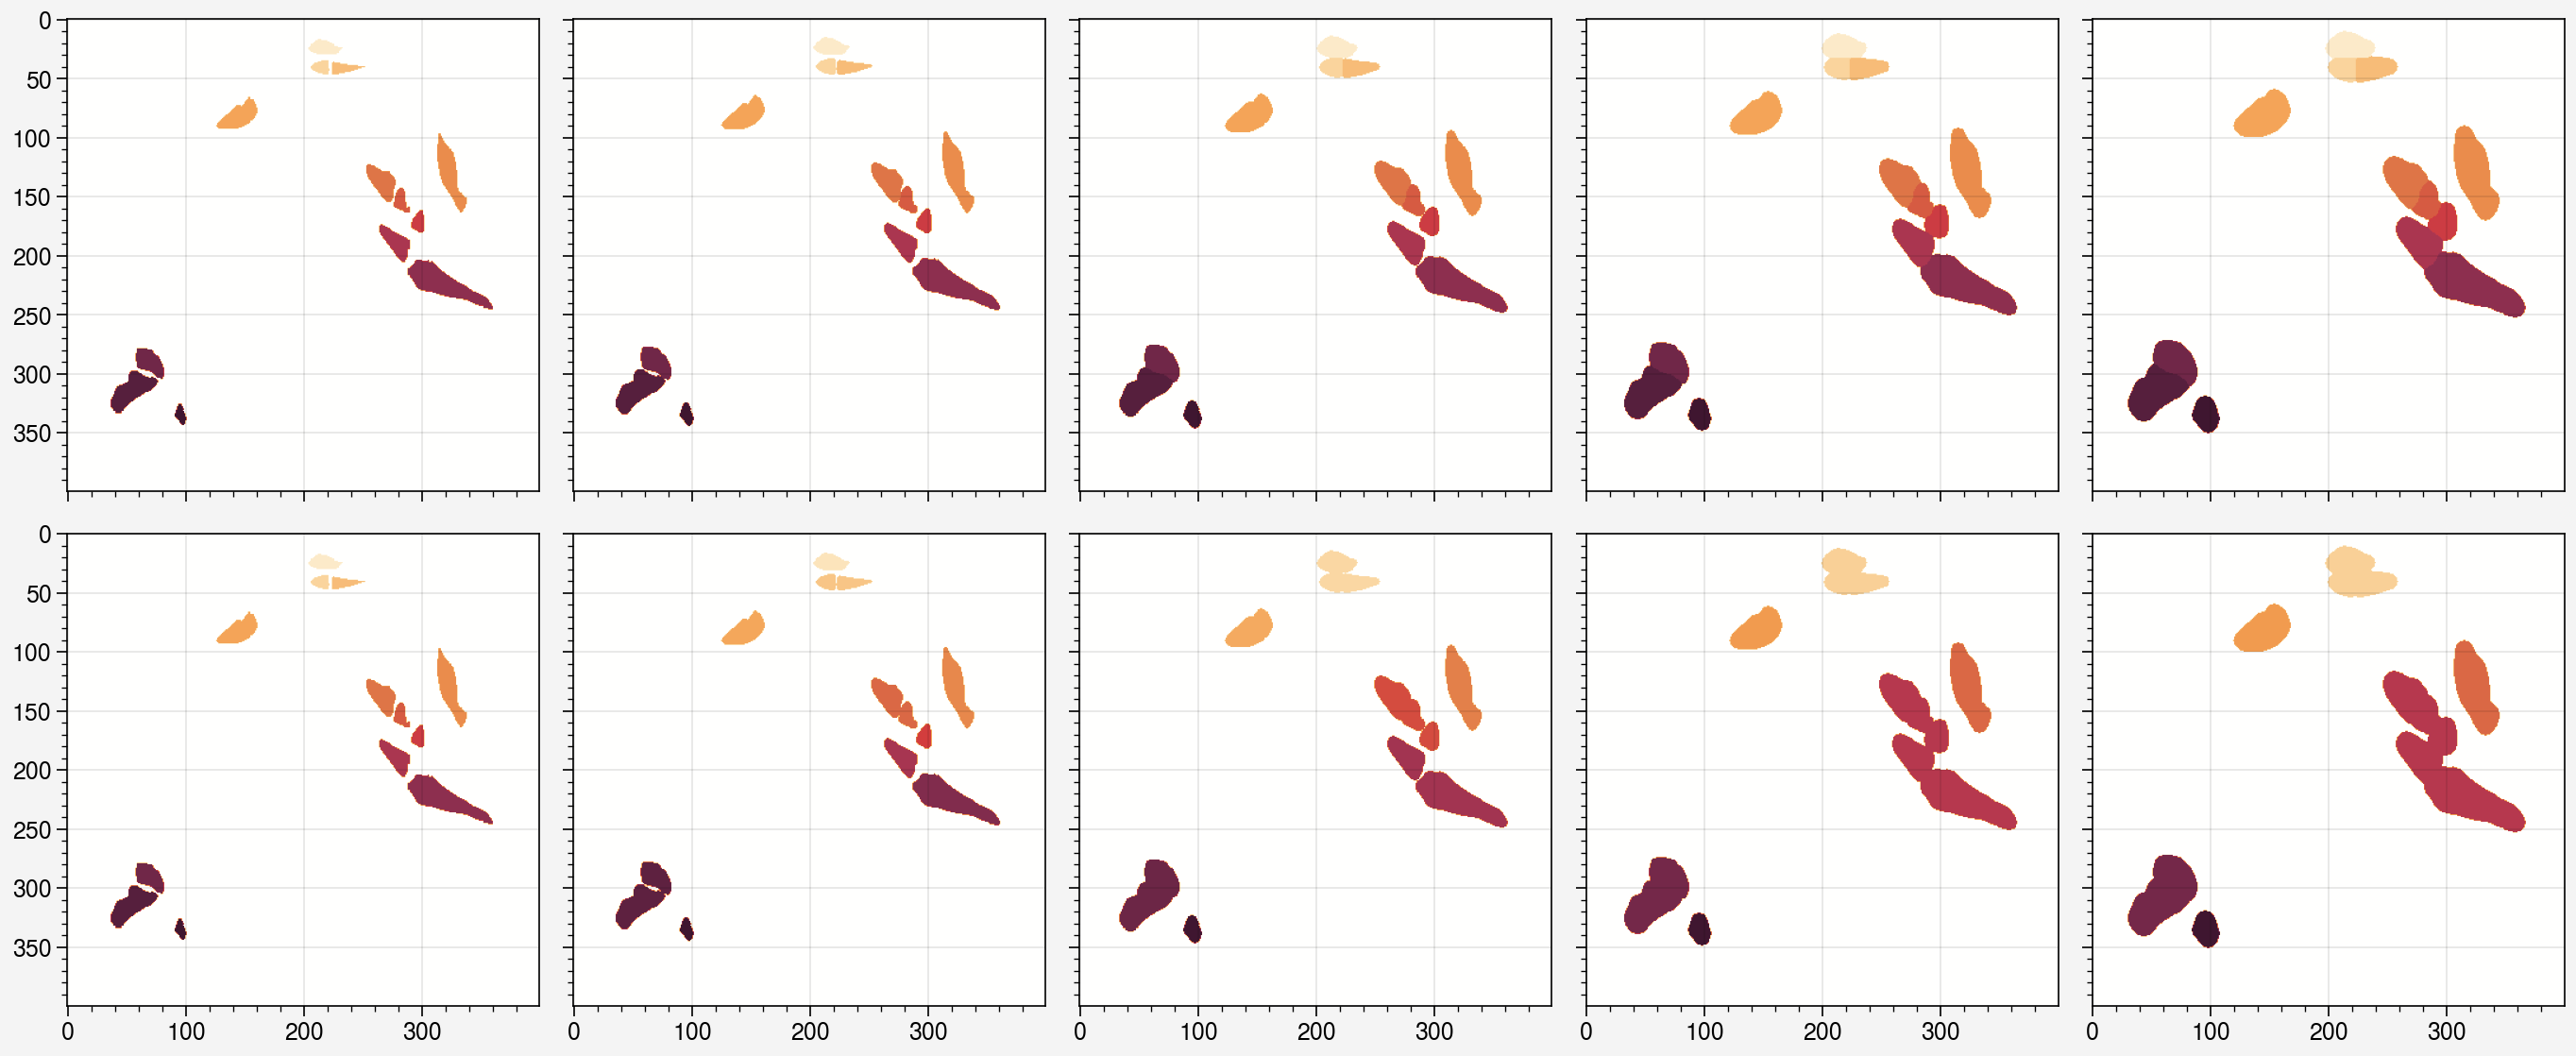

In [348]:
fig, axs = pplt.subplots(ncols=5, nrows=2)
axs[0, 0].imshow(gt_img)
axs[1, 0].imshow(gt_img)
for ax, n in zip(axs[0, 1:], expand_no_overlap):
    ax.imshow(expand_no_overlap[n])
for ax, n in zip(axs[1, 1:], dilation):
    ax.imshow(dilation[n])
# for ax, n in zip(axs[1, 1:], erosion):
#     ax.imshow(erosion[n])

In [357]:
compute_metrics(gt_img, dilation[n], weighted=True)

label_i                           6.881477
area_i                          530.043271
area_j                         2490.709205
overlap                         530.043271
relative_error_area              -5.847440
area_similarity_ratio             0.270675
undersegmentation_error           0.729325
oversegmentation_error            0.000000
segmentation_error                0.592413
euclidean_distance               10.579952
hausdorff_distance               34.023789
modified_hausdorff_distance      11.297031
shape_dissimilarity               5.847440
n                                 6.000000
dtype: float64

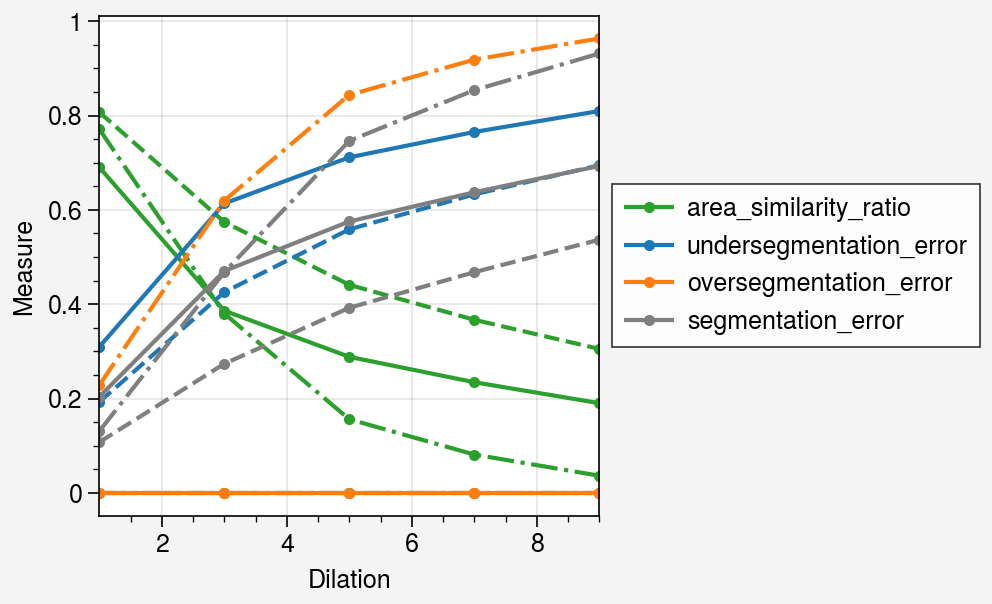

In [363]:
results_erode = pd.DataFrame(results_erode)
results_expansion = pd.DataFrame(results_expansion)
results_dilation = pd.DataFrame(results_dilation)

fig, ax = pplt.subplots()
for color, measure in  zip(['tab:green', 'tab:blue', 'tab:orange', 'tab:gray'],
                           ['area_similarity_ratio', 'undersegmentation_error', 'oversegmentation_error', 'segmentation_error']):
    ax.plot(results_dilation.columns, results_dilation.loc[measure], marker='.', label=measure, ls='-', color=color)
    ax.plot(results_expansion.columns, results_expansion.loc[measure], marker='.', label='', ls='--', color=color)
    ax.plot(results_erode.columns, results_erode.loc[measure], marker='.', label='', ls='-.', color=color)
ax.legend(ncols=1, loc='r')
ax.format(ylabel='Measure', xlabel='Dilation')

In [366]:
results_erode

,1,3,5,7,9
label_i,7.000000,7.000000,6.818182,8.142857,8.000000
area_i,412.307692,412.307692,461.909091,622.714286,809.000000
area_j,335.384615,194.230769,100.454545,61.000000,41.500000
overlap,335.384615,194.230769,100.454545,61.000000,41.500000
relative_error_area,0.228622,0.619668,0.843703,0.918492,0.963394
area_similarity_ratio,0.771378,0.380332,0.156297,0.081508,0.036606
undersegmentation_error,0.000000,0.000000,0.000000,0.000000,0.000000
oversegmentation_error,0.228622,0.619668,0.843703,0.918492,0.963394
segmentation_error,0.131030,0.467903,0.746317,0.853776,0.931506
euclidean_distance,0.252658,0.965945,2.217604,3.646823,7.726859


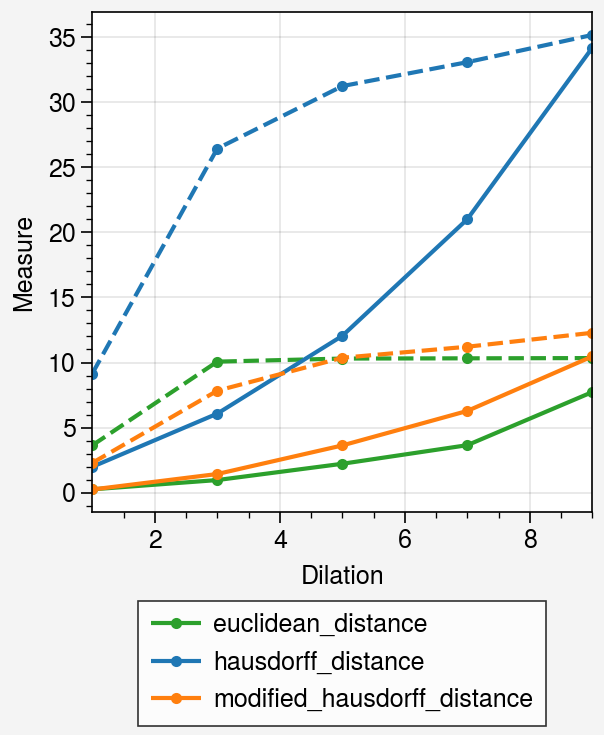

In [360]:
results = pd.DataFrame(results)
fig, ax = pplt.subplots()
for color, measure in  zip(['tab:green', 'tab:blue', 'tab:orange'],
                           ['euclidean_distance', 'hausdorff_distance', 'modified_hausdorff_distance']):
    ax.plot(results_erode.columns, results_erode.loc[measure], marker='.', label=measure, ls='-', color=color)
    ax.plot(results_dilation.columns, results_dilation.loc[measure], marker='.', label='', ls='--', color=color)
ax.legend(ncols=1, loc='b')
ax.format(ylabel='Measure', xlabel='Dilation')

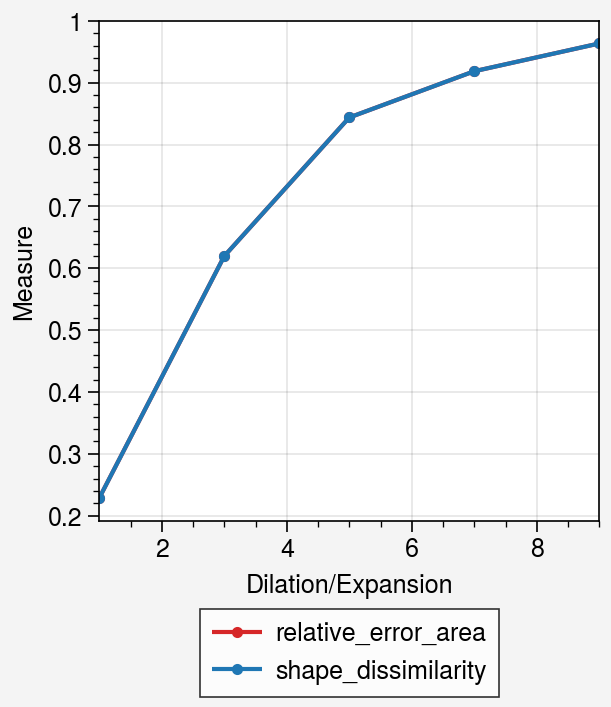

In [342]:

fig, ax = pplt.subplots()
for color, measure in zip(['tab:red', 'tab:blue'],  ['relative_error_area', 'shape_dissimilarity']):
    ax.plot(results_erode.columns, results_erode.loc[measure], marker='.', label=measure, ls='-', color=color)
    ax.plot(results_expansion.columns, results_expansion.loc[measure], marker='.', label='', ls='--', color=color)
ax.legend(ncols=1, loc='b')
ax.format(ylabel='Measure', xlabel='Dilation/Expansion')

In [182]:
import skimage
results = []

def distance(p1, p2):
    return np.round(np.sqrt((p1[0] - p2[0])**2 + (p1[0] - p2[1])**2), 2)
    
for case in ['021_aqua']:
    
    man_img = skimage.measure.label(lb_images[case][0,:,:])
    ift_img = ift_lb_images[case][0,:,:] # assumes it's labeled. If not, would need to label it.
    tc_img = tc_images[case]
    land_mask_img = landfast_images[case]
    
    # get the labels from the manual image
    man_img_props = skimage.measure.regionprops(man_img)
    ift_img_props = skimage.measure.regionprops(ift_img)
    man_img_props = {floe.label: floe for floe in man_img_props}
    ift_img_props = {floe.label: floe for floe in ift_img_props}
    # simple true positive: only one IFT label intersects with the manual label and vice versa
    # simple oversegmentation: multiple IFT labels with one manual label
    # simple undersegmentation: single IFT label with multiple manual label
    
    matches = []
    for floe_id in man_img_props:
        # List of IFT floes with nonzero overlap to manual
        ift_matches_manual = np.unique(ift_img[man_img == floe_id])
    
        # List of manual floes with nonzero overlap to the selected IFT floes
        for ift_floe_id in ift_matches_manual:
            if ift_floe_id > 0:
                matches.append([floe_id, ift_floe_id])
    
    match_df = pd.DataFrame(matches, columns=['manual_id', 'ift_id'])
    ift_dupes_df = match_df.loc[match_df.duplicated(subset='ift_id', keep=False)]
    match_df = match_df.loc[~match_df.duplicated(subset='ift_id', keep=False), ]
    
    for row, data in match_df.iterrows():
        underestimate = (man_img == data.manual_id) & (ift_img != data.ift_id)
        overestimate = (man_img != data.manual_id) & (ift_img == data.ift_id)
        a_cap_b = (man_img == data.manual_id) & (ift_img == data.ift_id)
        a_cup_b = (man_img == data.manual_id) | (ift_img == data.ift_id)
    
        match_df.loc[row, 'jaccard_index'] = np.round(np.sum(a_cap_b)/np.sum(a_cup_b), 2)
        match_df.loc[row, 'edge_error'] = np.sum(underestimate | overestimate)
        match_df.loc[row, 'underestimate_error'] = np.sum(underestimate)
        match_df.loc[row, 'overestimate_error'] = np.sum(overestimate)
        match_df.loc[row, 'area'] = np.round(man_img_props[data.manual_id].area, 2)
        match_df.loc[row, 'perimeter'] = np.round(man_img_props[data.manual_id].perimeter, 2)
        match_df.loc[row, 'centeroid_error'] = distance(man_img_props[data.manual_id].centroid, ift_img_props[data.ift_id].centroid)
        match_df.loc[row, 'area_error'] = np.round(ift_img_props[data.ift_id].area - man_img_props[data.manual_id].area, 2)
        match_df.loc[row, 'perimeter_error'] = np.round(ift_img_props[data.ift_id].perimeter - man_img_props[data.manual_id].perimeter, 2)
    results.append(match_df)

In [221]:
def select_relevant_set(label_i, gt_image, seg_image, gt_image_props, seg_image_props, thresh=0.5):
    """Identifies the set of labels in the segmented image corresponding
    to the "Relevant Set". label_i is the label in the ground truth image (gt_image),
    seg_image is a labeled image with a set of candidate objects to match. gt_image_props and
    seg_image_props are the results of skimage.measure.regionprops placed into a dictionary by 
    label. Each object sj in seg_image with a nonzero overlap with object gi in the gt_image is checked
    for 4 criteria: centroid(gi) in sj; centroid(sj) in gi, relative overlap(gi, sj) > thresh, or
    relative overlap(sj, gi) > thresh. Relative overlap (a, b) is |a intersect b|/|b|.
    Returns a list of possible indices."""

    # First grab any labels that have a nonzero intersection.
    # This is \tilde Y from Clinton et al. 2010
    possible = [x for x in np.unique(seg_image[gt_image == label_i]) if x != 0]
    if len(possible) == 0:
        return []
        
    reference_set = []
    for j in possible:    
        # A: centroid(gi) in sj
        rg, cg = gt_image_props[label_i].centroid
        s_label = seg_image[int(np.round(r)), int(np.round(c))]
        
        in_A = s_label == j
        
        # B: centroid(sj) in gi
        rs, cs = seg_image_props[j].centroid
        g_label = gt_image[int(np.round(rs)), int(np.round(cs))]
        in_B = g_label == label_i
        
        # C: relative_overlap(g, s) > thresh
        overlap = np.sum((gt_image == label_i) & (seg_image == j))
        in_C = overlap/np.sum(seg_image == j) > thresh
        
        # D: relative_overlap(s, g) > thresh
        in_D = overlap/np.sum(gt_image == label_i) > thresh
        
        if np.any([in_A, in_B, in_C, in_D]):
            reference_set.append(j)

    #     # test
    # print('Label', label_i, 'Size', len(reference_set), 'A:', in_A, 'B: ', in_B, 'C: ', in_C, 'D: ', in_D)
    return reference_set

In [252]:
def apply_segmentation_metrics_ij(label_i, gt_image, label_j, seg_image,
                               gt_image_props, seg_image_props):
    """Produce a pandas Series object with the names of each measure as the index. Calculates measures for
    indivual pairs of objects. Inputs are the (integer) labels, the labeled images, and the dictionaries 
    with object properties returned by regionprops.
    
    Metrics calculated:

    relative_error_area
    area_similarity_ratio
    undersegmentation_error
    oversegmentation_error
    euclidean_distance
    hausdorff_distance
    modified_hausdorff_distance
    shape_dissimilarity
    directed_boundary_fscore
    """

    metric_results = {'label_i': label_i,
                      'label_j': label_j}

    area_g = gt_image_props[label_i].area
    area_s = seg_image_props[label_j].area
    area_gs = np.sum((gt_image == label_i) & (seg_image == label_j))


    metric_results['area_i'] = area_g
    metric_results['area_j'] = area_s
    metric_results['overlap'] = area_gs
    
    pr = area_gs/area_s
    re = area_gs/area_g
    f1_score = 2*(pr*re)/(pr+re)

    rg, cg = gt_image_props[label_i].centroid
    rs, cs = seg_image_props[label_j].centroid

    # area
    metric_results['relative_error_area'] = (area_g - area_s)/area_g
    metric_results['area_similarity_ratio'] = min(area_s, area_g)/max(area_s, area_g)
    metric_results['undersegmentation_error'] = 1 - pr
    metric_results['oversegmentation_error'] = 1 - re
    metric_results['segmentation_error'] = 1 - f1_score

    # location
    metric_results['euclidean_distance'] = np.sqrt((rg - rs)**2 + (cg - cs)**2)
    metric_results['hausdorff_distance'] = skimage.metrics.hausdorff_distance(gt_image == label_i, seg_image == label_j, method='standard')
    metric_results['modified_hausdorff_distance'] = skimage.metrics.hausdorff_distance(gt_image == label_i, seg_image == label_j, method='modified')

    # boundary
    metric_results['shape_dissimilarity'] = (np.sum((gt_image == label_i) & (seg_image != label_j)) + 
                                             np.sum((gt_image != label_i) & (seg_image == label_j))) / area_g

    # tbd: write function to calculate directed boundary score
    # metric_results['directed_boundary_fscore'] = dbf(gt_image, seg_image, r=5)
    

    return pd.Series(metric_results)

In [253]:
# Here's what would get called for each image
def compute_metrics(gt_image, seg_image, weighted=True):
    """Extract features from the ground truth and segmented image, then compute a series of metrics
    to measure the quality of the segmentation. Returns a pandas Series with measures calculated for 
    the full image. If "weighted=True", then weight by the ground truth object size before returning.
    """
    
    results = []
    for label_i in man_img_props:
        ref_set = select_relevant_set(label_i=label_i, gt_image=man_img, seg_image=ift_img,
                        gt_image_props=man_img_props, seg_image_props=ift_img_props, thresh=0.5)
    
        if len(ref_set) > 0:
            for label_j in ref_set:
                results.append(apply_segmentation_metrics_ij(label_i=label_i,
                                                             gt_image=man_img,
                                                             label_j=label_j,
                                                             seg_image=ift_img,
                                                             gt_image_props=man_img_props,
                                                             seg_image_props=ift_img_props))
    results = pd.DataFrame(results)
    
    # First average over the relevant sets
    results_i = results.groupby('label_j').mean()
    
    # The unweighted average
    unweighted_mean = results_i.mean(axis=0)
    
    # Weighted by area
    w = results_i.area_i / results_i.area_i.sum()
    weighted_mean = pd.Series(np.average(results_i, weights=w, axis=0), index=unweighted_mean.index)
    
    # In both cases, add the number of ground truth elements, as well
    weighted_mean['n'] = len(results_i)
    unweighted_mean['n'] = len(results_i)

    if weighted:
        return weighted_mean
        
    else:
        return unweighted_mean

In [192]:
for label in man_img_props:
    ref_set = select_relevant_set(label_i=label, gt_image=man_img, seg_image=ift_img,
                    gt_image_props=man_img_props, seg_image_props=ift_img_props, thresh=0.5)

    if len(ref_set) > 0:
        # get scores for each item
        # average 
    

Label 1 Size 1 A: False B:  False C:  False D:  True
Label 2 Size 1 A: False B:  True C:  True D:  False
Label 3 Size 1 A: False B:  False C:  False D:  True
Label 4 Size 1 A: False B:  True C:  True D:  True
Label 5 Size 1 A: False B:  False C:  False D:  True
Label 6 Size 1 A: False B:  True C:  True D:  True
Label 7 Size 2 A: False B:  True C:  True D:  False
Label 8 Size 1 A: False B:  False C:  False D:  True
Label 10 Size 3 A: False B:  True C:  True D:  False
Label 11 Size 1 A: False B:  True C:  True D:  True
Label 12 Size 2 A: False B:  True C:  True D:  False
Label 13 Size 1 A: False B:  True C:  True D:  False
Label 14 Size 3 A: False B:  True C:  True D:  False
Label 15 Size 1 A: False B:  False C:  False D:  True
Label 16 Size 1 A: False B:  True C:  True D:  True
Label 17 Size 1 A: False B:  True C:  True D:  False
Label 18 Size 1 A: False B:  False C:  False D:  True
Label 19 Size 1 A: False B:  False C:  False D:  True
Label 20 Size 1 A: False B:  True C:  True D:  Fals

# Example of reference set

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Label 14 Size 3 A: False B:  True C:  True D:  False


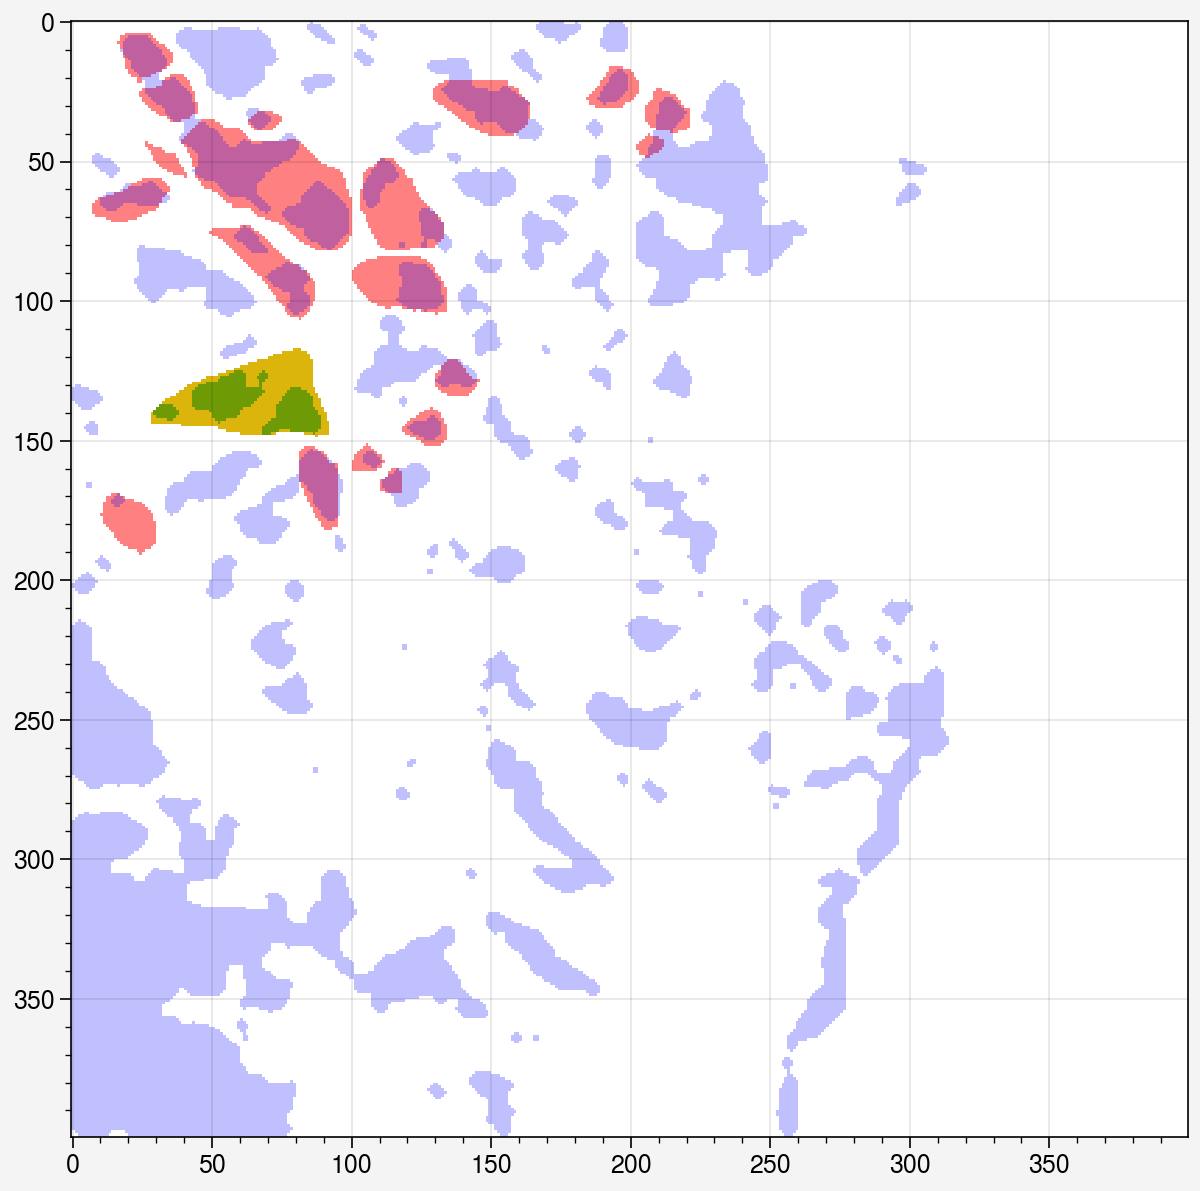

In [210]:
fig, ax = pplt.subplots(width=6)
ax.imshow(np.ma.masked_array(man_img, man_img==0), color='r', alpha=0.5)
ax.imshow(np.ma.masked_array(ift_img, ift_img==0), color='b', alpha=0.25)

# Example of relevant set
label_i = 14
ax.imshow(np.ma.masked_array(man_img, man_img != label_i), color='gold', alpha=1)

labels_j = select_relevant_set(label_i=label_i, gt_image=man_img, seg_image=ift_img,
                    gt_image_props=man_img_props, seg_image_props=ift_img_props, thresh=0.5)
for j in labels_j:
    ax.imshow(np.ma.masked_array(ift_img, ift_img != j), color='green', alpha=0.5)

In [254]:
results

,label_i,label_j,area_i,area_j,overlap,relative_error_area,area_similarity_ratio,undersegmentation_error,oversegmentation_error,segmentation_error,euclidean_distance,hausdorff_distance,modified_hausdorff_distance,shape_dissimilarity
0,1,11,272.0,1162.0,202,-3.272059,0.234079,0.826162,0.257353,0.718271,35.266258,63.245553,28.451377,3.786765
1,2,81,228.0,109.0,109,0.521930,0.478070,0.000000,0.521930,0.353116,0.502103,4.123106,1.036716,0.521930
2,3,11,274.0,1162.0,203,-3.240876,0.235800,0.825301,0.259124,0.717270,17.163391,43.829214,16.422830,3.759124
3,4,48,573.0,561.0,393,0.020942,0.979058,0.299465,0.314136,0.306878,2.066569,9.000000,1.296332,0.607330
4,5,88,218.0,2570.0,119,-10.788991,0.084825,0.953696,0.454128,0.914634,34.018100,62.393910,29.857331,11.697248
5,6,22,85.0,66.0,51,0.223529,0.776471,0.227273,0.400000,0.324503,2.742843,4.000000,0.802739,0.576471
6,7,11,1731.0,1162.0,694,0.328712,0.671288,0.402754,0.599076,0.520221,30.151956,39.698866,7.897034,0.869440
7,7,27,1731.0,404.0,404,0.766609,0.233391,0.000000,0.766609,0.621546,20.445797,44.407207,13.607304,0.766609
8,8,88,76.0,2570.0,45,-32.815789,0.029572,0.982490,0.407895,0.965986,28.091981,60.033324,29.662219,33.631579
9,10,36,732.0,159.0,158,0.782787,0.217213,0.006289,0.784153,0.645342,11.956162,26.419690,8.502694,0.785519


array([1.10791205e+01, 9.62788604e+02, 3.22926883e+02, 2.22551663e+02,
       2.22060438e-01, 2.77561379e-01, 1.09419462e-01, 7.05360882e-01,
       6.41222580e-01, 1.48867186e+01, 3.20042837e+01, 1.12933411e+01,
       1.18866133e+00])

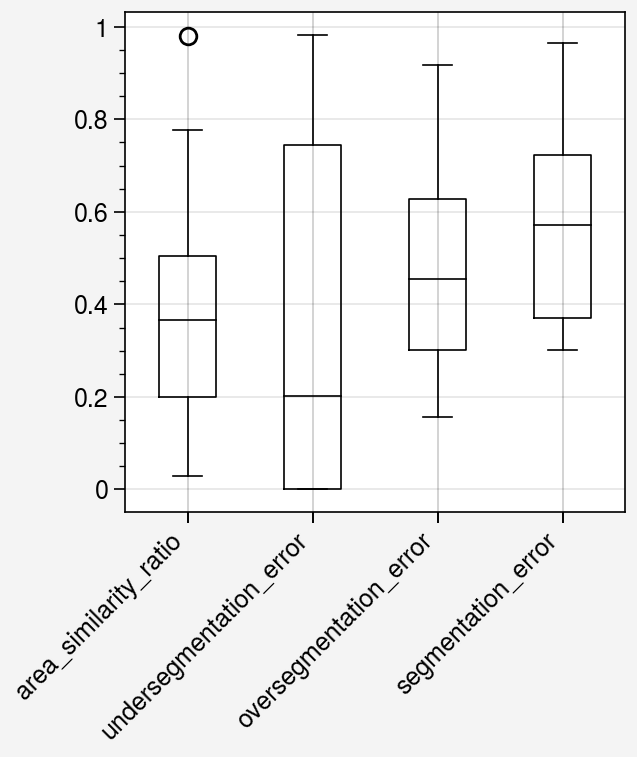

In [232]:
bounded_01 = ['area_similarity_ratio', 'undersegmentation_error', 'oversegmentation_error',
       'segmentation_error']
fig, ax = pplt.subplots()
ax.box(results.groupby('label_i').mean().loc[:, bounded_01])
ax.format(xrotation=45)

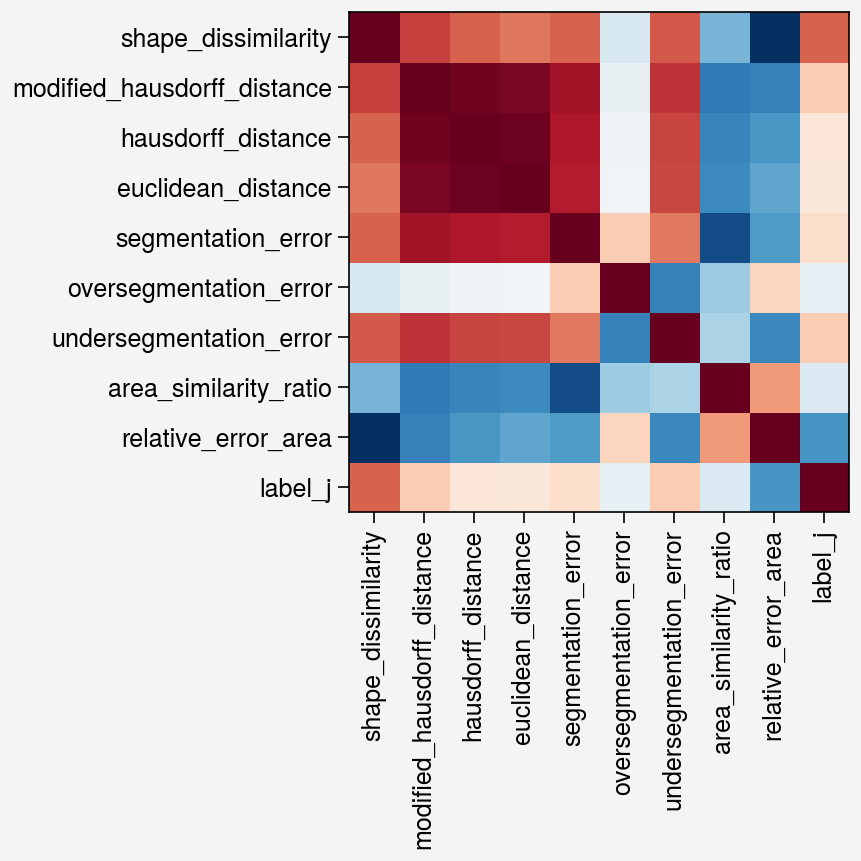

In [237]:
fig, ax = pplt.subplots()
ax.heatmap(results.groupby('label_i').mean().corr())
ax.format(xrotation=90, xreverse=True)

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


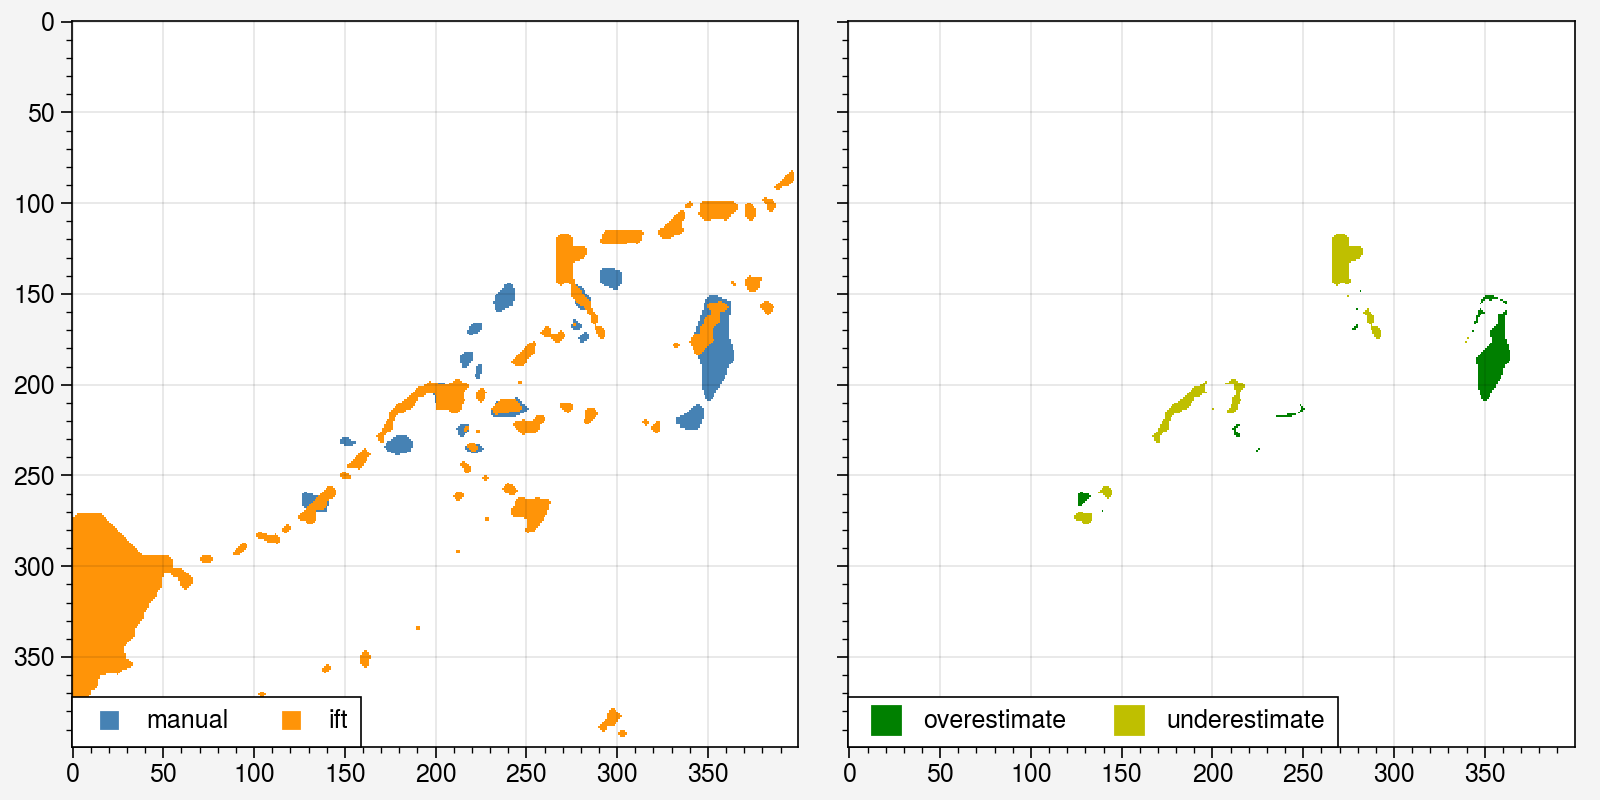

In [60]:
# over/underestimation from Goessling et al. 206 adapted to floe-by-floe
fig, axs = pplt.subplots(width=8, height=4, ncols=2)
axs[0].imshow(np.ma.masked_array(man_img, mask=man_img == 0), color='steelblue', alpha=1)
axs[0].imshow(np.ma.masked_array(ift_img, mask=ift_img == 0), color='tangerine', alpha=1)

for row, data in match_df.iterrows():
    man_floe_id = data.manual_id
    ift_floe_id = data.ift_id
    edge_error = ((man_img == man_floe_id) & (ift_img != ift_floe_id)) | ((man_img != 108) & (ift_img == 24))
    underestimate = (man_img == man_floe_id) & (ift_img != ift_floe_id)
    overestimate = (man_img != man_floe_id) & (ift_img == ift_floe_id)
    axs[1].imshow(np.ma.masked_array(edge_error > 0, mask=~underestimate), color='g', alpha=1)
    axs[1].imshow(np.ma.masked_array(edge_error > 0, mask=~overestimate), color='y', alpha=1)

for color, label in zip(['steelblue', 'tangerine'], ['manual', 'ift']):
    axs[0].plot([],[],m='s', lw=0, color=color, alpha=1, label=label)
axs[0].legend(loc='ll', ncols=2, alpha=1)    
for color, label in zip(['green', 'y'], ['overestimate', 'underestimate']):
    axs[1].plot([],[],m='s', lw=0, color=color, alpha=1, label=label)
axs[1].legend(loc='ll', ncols=2, alpha=1, ms=10)    

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


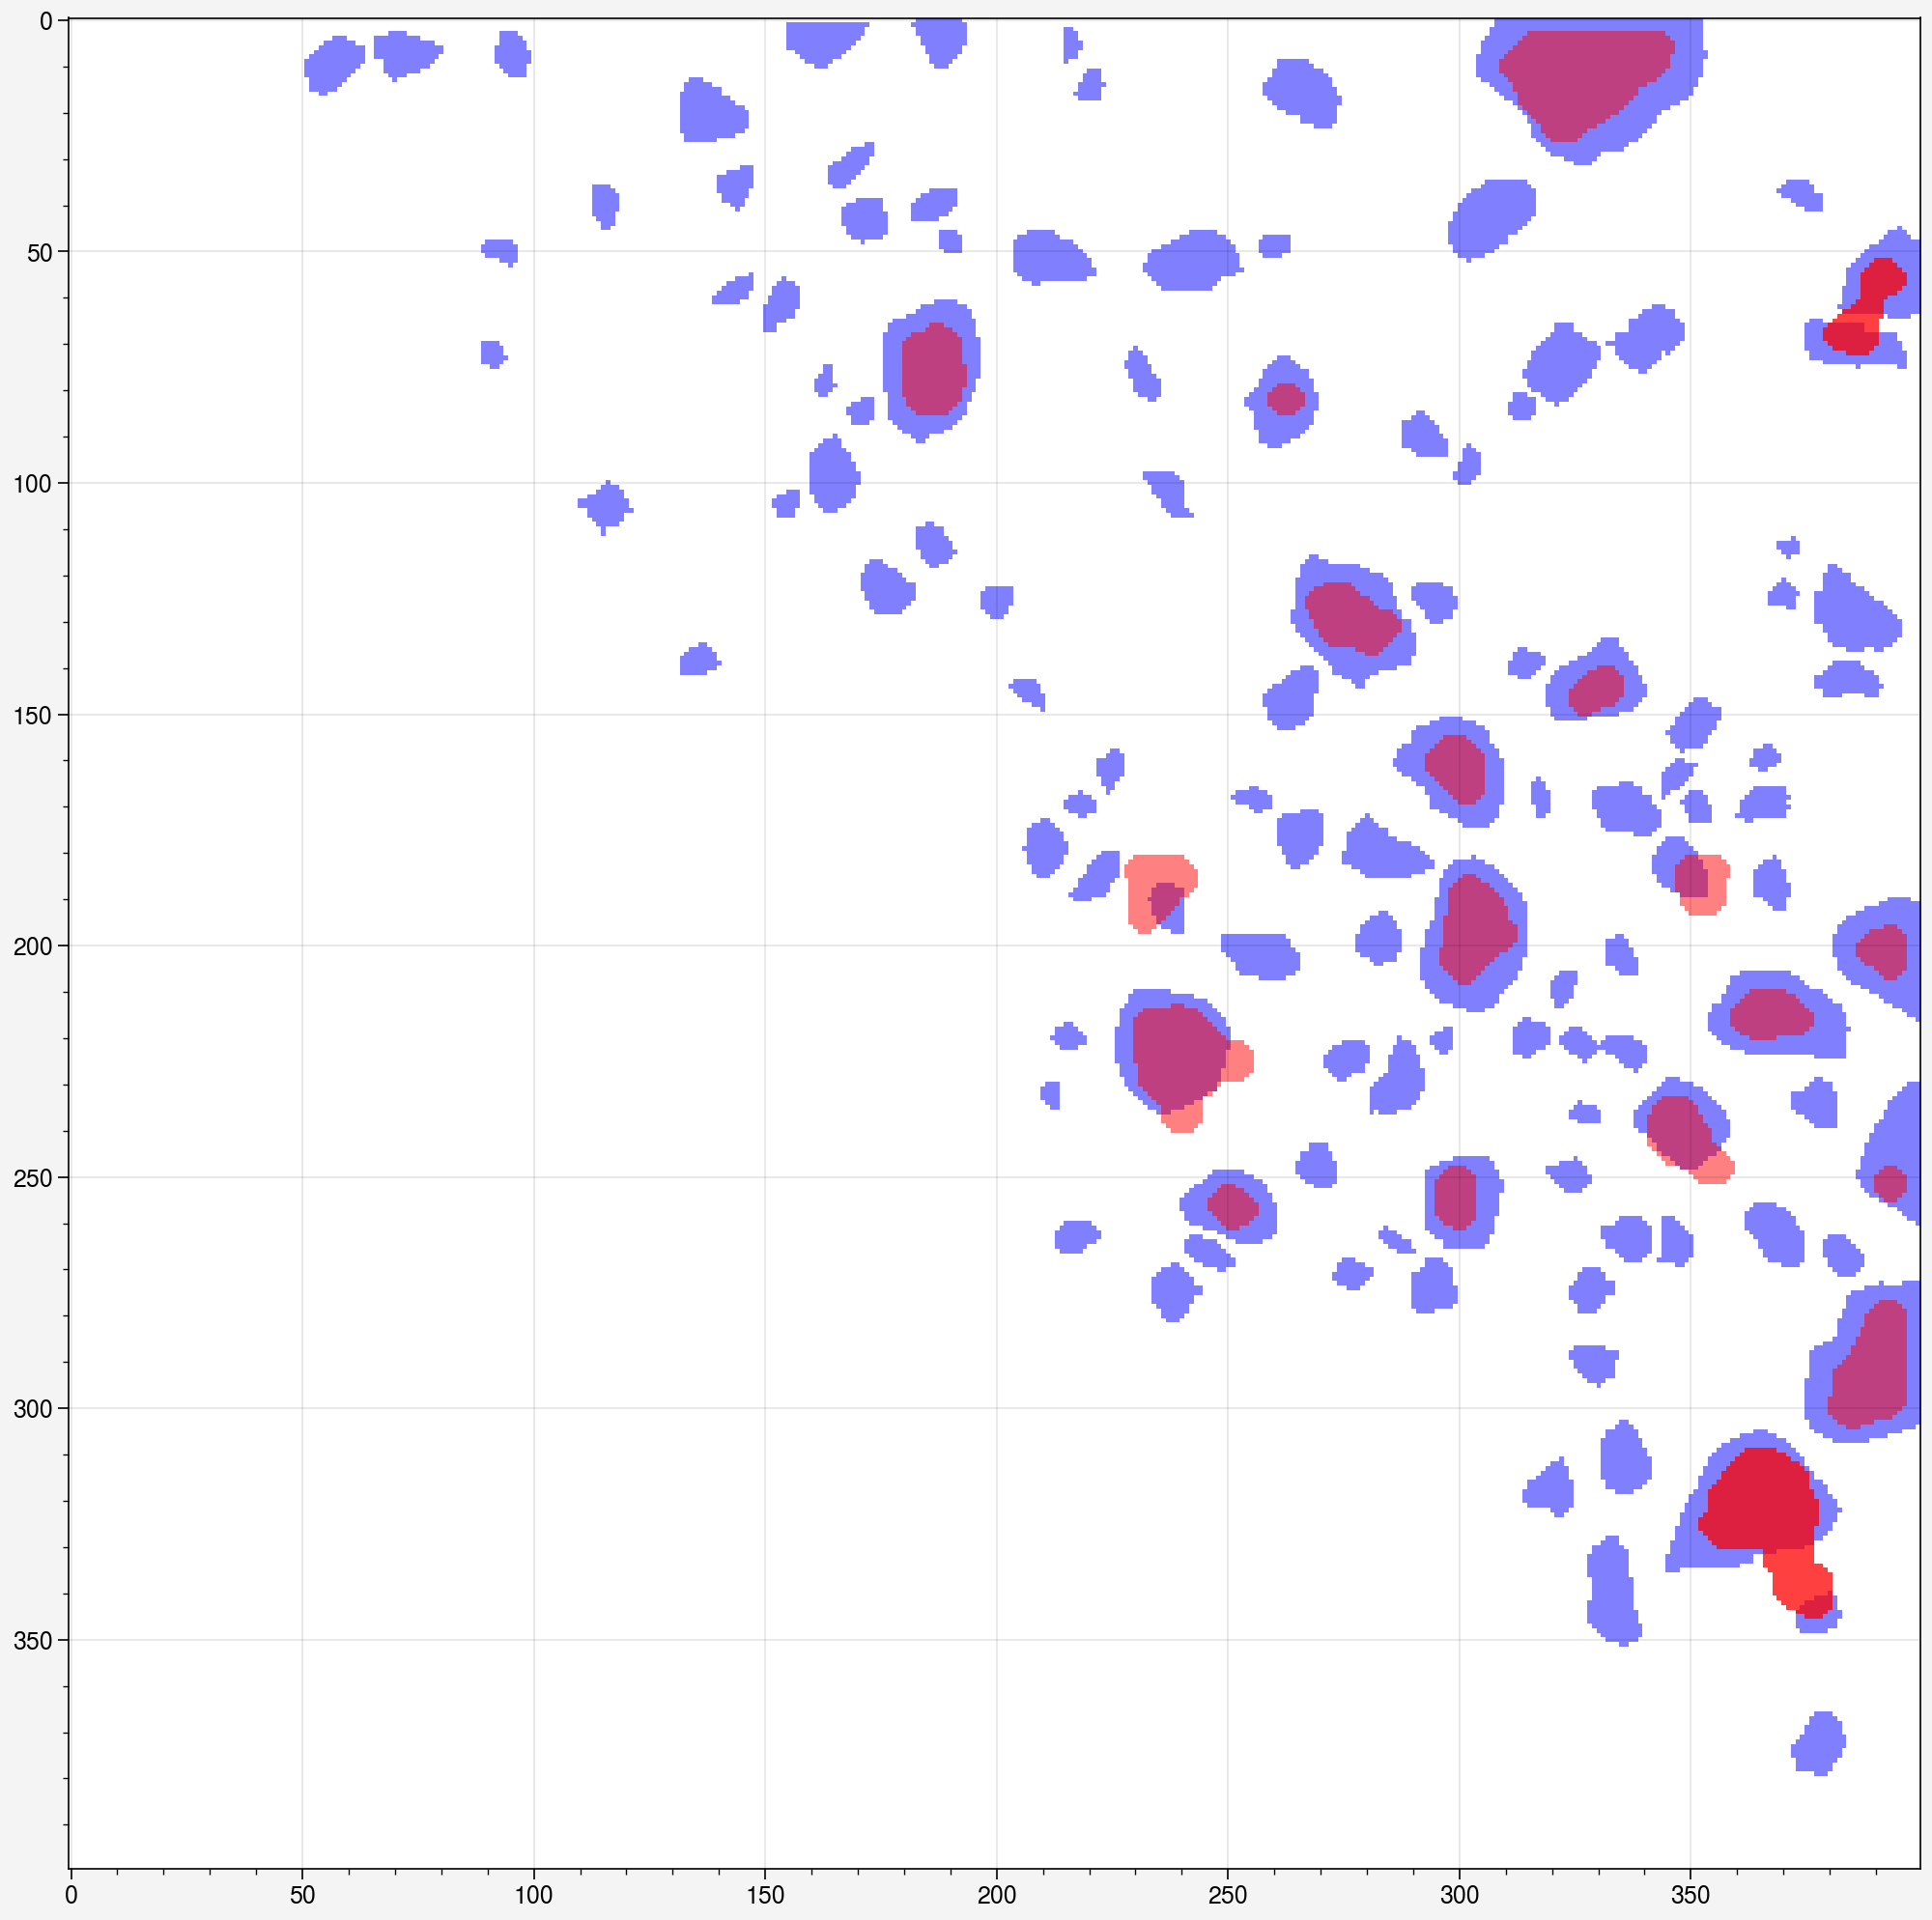

In [191]:
fig, ax = pplt.subplots(width=10)
ax.imshow(np.ma.masked_array(man_img, mask=man_img == 0), color='b', alpha=0.5)
for floe_id in man_img_props:
    
    matches = np.unique(ift_img[man_img == floe_id])
    if np.any(matches > 0):
        if len(matches[matches != 0]) == 1:
            ift_floe_id = matches[matches != 0][0]
            ax.imshow(np.ma.masked_array(ift_img, mask=ift_img != ift_floe_id), color='r', alpha=0.5)

In [157]:
from skimage.metrics import adapted_rand_error, variation_of_information
error, precision, recall = adapted_rand_error(man_img, ift_img)
error, precision, recall

(0.9628331935985566, 0.6345415265067076, 0.019144062864835002)

In [ ]:
import cv2
from copy import deepcopy
import numpy as np
import h5py
import sys
from pandas import Series
from filter_function import ift_filter

IOU_THRESHOLD = 0.5

    # Manual image loading
    raw_manual_img = cv2.imread(manual_path)
    manual_img = np.zeros((len(raw_manual_img), len(raw_manual_img[0])))
    idx = raw_manual_img[:,:,0] > 0
    manual_img[idx] = 255

    # Get individual manual floes
    man_num_labels, man_labels, man_stats, man_centroids = cv2.connectedComponentsWithStats(
                                                            manual_img.astype('uint8'), connectivity=8)

    ift_to_manual_floes = {}
    false_positives = []

    # Assume a floe is a false positive until we find an IFT one that corresponds
    false_negatives = list(range(1, man_num_labels))

    # Get IFT overlaps with real floes
    for i in range(1, ift_num_labels):

        # Get indices of points in ift image corresponding to floes
        idx = ift_labels[:,:] == i

        # Check if this floe intersects the landmask
        landmask_intersection = np.logical_and(idx, idx_landmass)

        # If it does, skip this floe for the purposes of calculation
        if np.sum(landmask_intersection) > 0:
            continue

        # Get manual floes in that area.
        manual_area = man_labels[idx]

        # Get the unique numbers of manual floes in that area.
        overlapping_manual = list(set(manual_area))

        # Add to dict based on result
        # If no overlapping real floes, false positive IFT result.
        if len(overlapping_manual) == 1 and overlapping_manual[0] == 0:
            false_positives.append(i)
        
        # Otherwise, add index of real manual floes to dictionary.
        else:
            if 0 in overlapping_manual:
                overlapping_manual.remove(0)
            ift_to_manual_floes[int(i)] = overlapping_manual

            # Remove false negatives
            for floe in overlapping_manual:
                if floe in false_negatives:
                    false_negatives.remove(floe)


    # Can consider the similarity of the floe pairings in the dictionary
    for key, value in ift_to_manual_floes.items():

        # Create list for all real floes matching this predicted floe.
        new_val = []


        # Generate countours of this floe for boundary iou and dilate
        floe_img_idx = ift_labels[:,:] == key
        binary_img = np.zeros_like(floe_img_idx, dtype=np.uint8)
        binary_img[floe_img_idx] = 255
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_img = np.zeros_like(binary_img)
        cv2.drawContours(contour_img, contours, 0, (255))
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
        dilated_predicted_boundary = cv2.dilate(contour_img, kernel, iterations=1)

        dilated_pred_boundary_idx = np.logical_and(dilated_predicted_boundary[:,:] > 0, ift_labels[:,:] != key)
        dilated_predicted_boundary = np.zeros_like(dilated_pred_boundary_idx, dtype=np.uint8)
        dilated_predicted_boundary[dilated_pred_boundary_idx] = 255

        # Get dilated area
        dilated_predicted_area = np.sum(dilated_predicted_boundary[:,:] == 255)
        
        
        for real_floe in value:


            intersection_stats = {}

            intersection_idx = np.logical_and(ift_labels[:,:] == key, man_labels[:,:] == real_floe)

            intersection_area = np.sum(intersection_idx)

            iou = intersection_area / (man_stats[real_floe][4] + ift_stats[key][4] - intersection_area)

            centroid_distance_px = np.sqrt((man_centroids[real_floe][0] - ift_centroids[key][0])**2 + 
                                (man_centroids[real_floe][1] - ift_centroids[key][1])**2)


            # Get dilated real floe boundary
            floe_img_idx = man_labels[:,:] == real_floe
            binary_img = np.zeros_like(floe_img_idx, dtype=np.uint8)
            binary_img[floe_img_idx] = 255
            contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour_img = np.zeros_like(binary_img)
            cv2.drawContours(contour_img, contours, 0, (255))
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
            dilated_real_boundary = cv2.dilate(contour_img, kernel, iterations=1)


            dilated_real_boundary_idx = np.logical_and(dilated_real_boundary[:,:] > 0, man_labels[:,:] == real_floe)
            dilated_real_boundary = np.zeros_like(dilated_real_boundary_idx, dtype=np.uint8)
            dilated_real_boundary[dilated_real_boundary_idx] = 255

            dilated_real_area = np.sum(dilated_real_boundary[:,:] == 255)


            # Calculate boundary iou
            intersection_idx = np.logical_and(dilated_real_boundary[:,:] == 255, dilated_predicted_boundary[:,:] == 255)
            bound_intersection_area = np.sum(intersection_idx)
            boundary_iou = bound_intersection_area / (dilated_real_area + dilated_predicted_area - bound_intersection_area)

            intersection_stats['area_percent_difference'] = (ift_stats[key][4] - man_stats[real_floe][4]) / man_stats[real_floe][4]
            intersection_stats['real_floe'] = int(real_floe)
            intersection_stats['iou'] = iou
            intersection_stats['centroid_distance'] = centroid_distance_px
            intersection_stats['boundary_iou'] = boundary_iou
            new_val.append(intersection_stats)

        ift_to_manual_floes[key] = new_val

    # Copy intersection stats for later
    intersections = deepcopy(ift_to_manual_floes)


    # Non-max suppression
    # Takes care of undersegmentation errors
    for ift, reals in ift_to_manual_floes.items():

        # Gets index of best matching real floe for IFT floe
        possible_match_idx = max(enumerate(reals), key=lambda x: x[1]['iou'])[0]
        
        # Removes best matching from list of IFT floes
        possible_match = reals.pop(possible_match_idx)

        # Adds remainder of floes (besides best match) to false negative list
        for non_match in reals:
            real_floe_number = non_match['real_floe']
            false_negatives.append({'floe_number': real_floe_number, 
                                    'floe_area': int(man_stats[real_floe_number][4]), 
                                    'overlap': True})

        # Sets ift_to_manual key to remaining best match
        ift_to_manual_floes[ift] = possible_match



    # Pair predicted floes to their best predictions
    # Takes care of oversegmentation errors
    to_remove = set()
    for ift1, real1 in ift_to_manual_floes.items():

        for ift2, real2 in ift_to_manual_floes.items():

            if ift1 != ift2 and real1['real_floe'] == real2['real_floe'] and real1['iou'] > real2['iou']:
                to_remove.add(ift2)

    
    for idx in list(to_remove):
        false_positives.append({'floe_number': idx, 
                                    'floe_area': int(ift_stats[idx][4]), 'overlap': True})
        del ift_to_manual_floes[idx]

    """
    After NMS, we have a list of FN and FP floes and a dict with predictions as keys and
    best matching real floes as values. Other real floes have been discarded as FNs.
    After NMS, the next step is determining whether the remaining pairings are good pairings.
    """

    to_remove = []
    for ift, real in ift_to_manual_floes.items():
        if real['boundary_iou'] < IOU_THRESHOLD and real['iou'] < IOU_THRESHOLD:
            to_remove.append(ift)

    for idx in to_remove:
        false_positives.append({'floe_number': idx, 
                                'floe_area': int(ift_stats[idx][4]), 'overlap': True})
        real_floe_number = ift_to_manual_floes[idx]['real_floe']
        false_negatives.append({'floe_number': real_floe_number, 
                                'floe_area': int(man_stats[real_floe_number][4]), 'overlap': True})
        del ift_to_manual_floes[idx]

    # Modify false positives to include floe information
    for i in range(len(false_positives)):
        if isinstance(false_positives[i], dict):
            continue
        else:
            floe_number = false_positives[i]
            floe_dict = {}
            floe_dict['floe_number'] = int(floe_number)
            floe_dict['floe_area'] = int(ift_stats[floe_number][4])
            floe_dict['overlap'] = False
            false_positives[i] = floe_dict

        
    # Modify false negatives to include floe information
    for i in range(len(false_negatives)):
        if isinstance(false_negatives[i], dict):
            continue
        else:
            floe_number = false_negatives[i]
            floe_dict = {}
            floe_dict['floe_number'] = int(floe_number)
            floe_dict['floe_area'] = int(man_stats[floe_number][4])
            floe_dict['overlap'] = False
            false_negatives[i] = floe_dict

    floe_conf_matrix = {'t_pos_floes': len(ift_to_manual_floes), 'f_pos_floes': len(false_positives), 
                        'f_neg_floes': len(false_negatives), 't_neg_floes': 1}


    ift_to_manual_tp = {}
    for k, v in ift_to_manual_floes.items():
        ift_to_manual_tp[k] = {'real_floe': v['real_floe'], 'real_floe_area': int(man_stats[v['real_floe']][4]),
                                'ift_floe_area': int(ift_stats[k][4])}

    if threshold_params:
        props['TP'] = ''
        props['ift_path'] = ift_path

        for open, labeled in open_to_labeled_map.items():
            props.loc[props['label'] == labeled, 'TP'] = (open in ift_to_manual_tp.keys())

    return floe_conf_matrix, false_positives, false_negatives, ift_to_manual_tp, intersections, labeled_image, props